<a href="https://colab.research.google.com/github/lauragoon/Face-Mask-Detector/blob/main/cnn2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import keras
from tensorflow.keras import datasets, layers, models
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer
from keras.models import Model
from keras import optimizers
from keras.callbacks import ModelCheckpoint

In [3]:
def get_data(batch_size, directory):
  
  datagen = image.ImageDataGenerator(rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, rescale=1./255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')
  dta = datagen.flow_from_directory(directory, class_mode='binary', batch_size=batch_size)

  return dta

In [4]:
## generate data
train_path = 'drive/Shared drives/DSCI 303 Final Project/ImageDataset2/training'
val_path = 'drive/Shared drives/DSCI 303 Final Project/ImageDataset2/validation'

train_data = get_data(50, train_path)
val_data = get_data(35, val_path)

resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(256,256,3))
output = resnet.layers[-1].output
output = keras.layers.Flatten()(output)
resnet = Model(resnet.input, output)
# resnet.summary()


##transfer learning with fine tuning
num_epochs = 100
steps_epoch = 100
steps_val = 50

resnet.trainable = True
for layer in resnet.layers:
    set_trainable = False
    if layer.name in ['res5c_branch2b', 'res5c_branch2c', 'activation_97']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model = models.Sequential()
model.add(resnet)
model.add(Dense(512, activation='relu', input_dim=(256,256,3)))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['accuracy'])
# model.summary()

filepath = "cnn.h5"
checkpt = ModelCheckpoint(filepath=filepath, monitor="val_accuracy", verbose=1, save_best_only=True, save_weights_only=False, mode="auto", save_freq="epoch")
callbacks_list = [checkpt]

history = model.fit(train_data, steps_per_epoch=steps_epoch, epochs=num_epochs, validation_data=val_data, validation_steps=steps_val, callbacks = callbacks_list, verbose=1)

Found 6804 images belonging to 2 classes.
Found 1954 images belonging to 2 classes.
94773248/94765736 [==============================] - 1s 0us/step
Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.7525 - accuracy: 0.5574 
Epoch 00001: val_accuracy improved from -inf to 0.69371, saving model to cnn.h5
100/100 [==============================] - 2172s 22s/step - loss: 0.7525 - accuracy: 0.5574 - val_loss: 0.6164 - val_accuracy: 0.6937
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.6555 - accuracy: 0.6151
Epoch 00002: val_accuracy improved from 0.69371 to 0.72343, saving model to cnn.h5
100/100 [==============================] - 716s 7s/step - loss: 0.6555 - accuracy: 0.6151 - val_loss: 0.5948 - val_accuracy: 0.7234
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.6153 - accuracy: 0.6728
Epoch 00003: val_accuracy improved from 0.72343 to 0.73029, saving model to cnn.h5
100/100 [==============================] - 421s

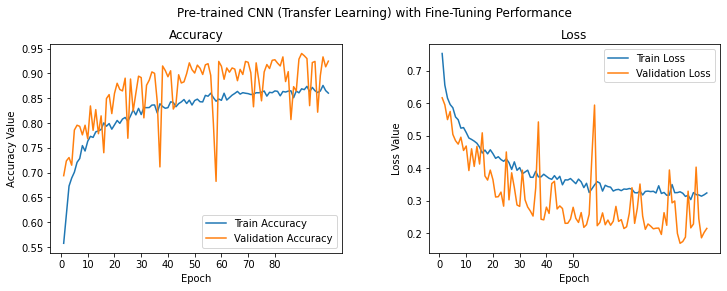

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Pre-trained CNN (Transfer Learning) with Fine-Tuning Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,101))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 81, 10))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")  

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 51, 10))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [ ]:
model.save('cnn_transfer.h5') 

In [7]:
## code to display model results
## from https://github.com/dipanjanS/practical-machine-learning-with-python/blob/master/notebooks/Ch05_Building_Tuning_and_Deploying_Models/model_evaluation_utils.py

from sklearn import metrics
import numpy as np
import pandas as pd

def get_metrics(true_labels, predicted_labels):

    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        4))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    
def display_confusion_matrix(true_labels, predicted_labels, classes=[1,0]):
    
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels, 
                                  labels=classes)
    cm_frame = pd.DataFrame(data=cm, 
                            columns=pd.MultiIndex([['Predicted:'], classes], 
                                                  level_labels), 
                            index=pd.MultiIndex([['Actual:'], classes], 
                                                level_labels)) 
    print(cm_frame) 
    
def display_classification_report(true_labels, predicted_labels, classes=[1,0]):

    report = metrics.classification_report(y_true=true_labels, 
                                           y_pred=predicted_labels, 
                                           labels=classes) 
    print(report)


def display_model_performance_metrics(true_labels, predicted_labels, classes=[1,0]):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, 
                                  classes=classes)
    print('\nPrediction Confusion Matrix:')
    print('-'*30)
    display_confusion_matrix(true_labels=true_labels, predicted_labels=predicted_labels, 
                             classes=classes)

In [10]:
from keras.models import load_model

cnn_model = load_model('cnn.h5')

test_path = 'drive/Shared drives/DSCI 303 Final Project/ImageDataset2/test'
test_data = get_data(200, test_path)
test_batch_images, test_batch_class = test_data.next()

predictions = cnn_model.predict_classes(test_batch_images)

display_model_performance_metrics(true_labels=test_batch_class, predicted_labels=predictions, 
                                      classes=list(set(test_batch_class)))

Found 2228 images belonging to 2 classes.
Model Performance metrics:
------------------------------
Accuracy: 0.89
Precision: 0.891
Recall: 0.89
F1 Score: 0.8897

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         0.0       0.91      0.85      0.88        94
         1.0       0.88      0.92      0.90       106

    accuracy                           0.89       200
   macro avg       0.89      0.89      0.89       200
weighted avg       0.89      0.89      0.89       200


Prediction Confusion Matrix:
------------------------------
            Predicted:    
                   0.0 1.0
Actual: 0.0         80  14
        1.0          8  98


In [ ]:
# sources: https://towardsdatascience.com/a-comprehensive-hands-on-guide-to-transfer-learning-with-real-world-applications-in-deep-learning-212bf3b2f27a; https://towardsdatascience.com/deep-learning-using-transfer-learning-python-code-for-resnet50-8acdfb3a2d38